In [76]:
#Import the librairies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

import seaborn as sns

#Import the dataset
data = 'flight_data_2024_sample.csv'
flight_df = pd.read_csv(data)
print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

  diverted crs_elapsed_time actual_elapsed_time  air_time  distance  \
0        0            151.0

## Clean the Dataset

### Remove none important independent variables

In [77]:
print(flight_df.columns)

flight_df.drop(['taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
    'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)
print(flight_df.columns)

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')
Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'cancelled', 'distance'],
      dtype='object')


### Remove cancelled flights

In [78]:
flight_df = flight_df[flight_df['cancelled'] == 0]

print(flight_df)

      year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0     2024      4            18            4  2024-04-18                MQ   
1     2024      1             1            1  2024-01-01                AA   
2     2024     12            12            4  2024-12-12                9E   
3     2024      4             8            1  2024-04-08                WN   
4     2024      2            16            5  2024-02-16                WN   
...    ...    ...           ...          ...         ...               ...   
9995  2024      1            16            2  2024-01-16                WN   
9996  2024      7             5            5  2024-07-05                AA   
9997  2024      2            28            3  2024-02-28                MQ   
9998  2024      2            18            7  2024-02-18                DL   
9999  2024      3             1            5  2024-03-01                G4   

      op_carrier_fl_num origin       origin_city_name origin_st

## Create new categories

In [79]:
flight_df['small_delay'] = ((flight_df['dep_delay'] > 0) & (flight_df['dep_delay'] < 90)).astype(int)
flight_df['moderate_delay'] = ((flight_df['dep_delay'] >= 90) & (flight_df['dep_delay'] < 180)).astype(int)
flight_df['severe_delay'] = (flight_df['dep_delay'] >= 180).astype(int)
flight_df['no_delay'] = (flight_df['dep_delay'] <= 0).astype(int)

print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

    dest_state_nm crs_dep_time dep_time  dep_delay  cancelled  distance  \
0    South Dakota      

## Visualization

### Bar Charts

#### Delays by month and type

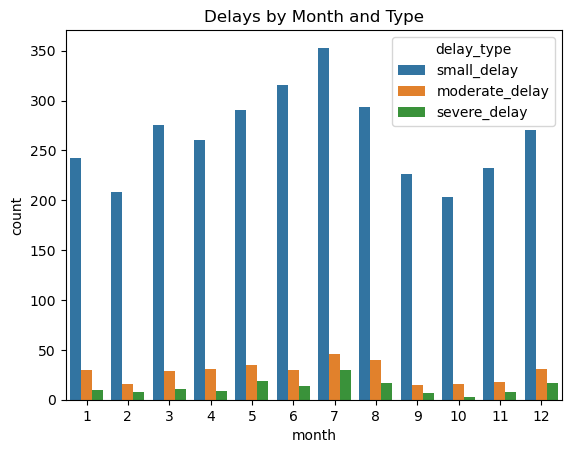

In [94]:
# Aggregate all delay categories by month
delay_types = ['small_delay', 'moderate_delay', 'severe_delay']
delay_by_month = flight_df.groupby('month')[delay_types].sum().reset_index()

# Melt to long-form for seaborn
delay_melted = delay_by_month.melt(id_vars='month', var_name='delay_type', value_name='count')

sns.barplot(x='month', y='count', hue='delay_type', data=delay_melted)
plt.title('Delays by Month and Type')
plt.show()


#### Delays by day of the week and type

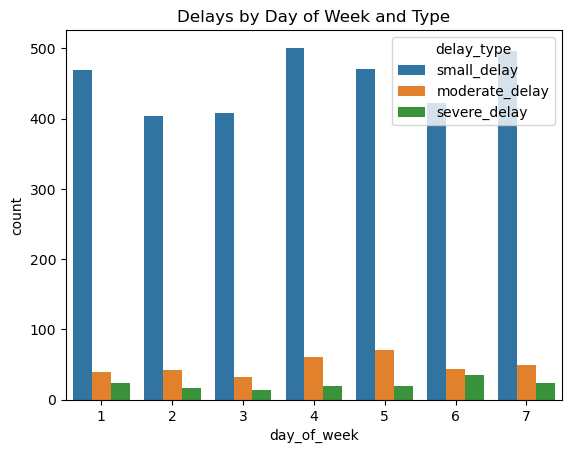

In [88]:
# Group by day_of_week, sum delay counts
delay_by_day = flight_df.groupby('day_of_week')[delay_types].sum().reset_index()

# Melt to long format for seaborn
delay_melted_day = delay_by_day.melt(id_vars='day_of_week', var_name='delay_type', value_name='count')

sns.barplot(x='day_of_week', y='count', hue='delay_type', data=delay_melted_day)
plt.title('Delays by Day of Week and Type')
plt.show()


#### Delays by carrier and type

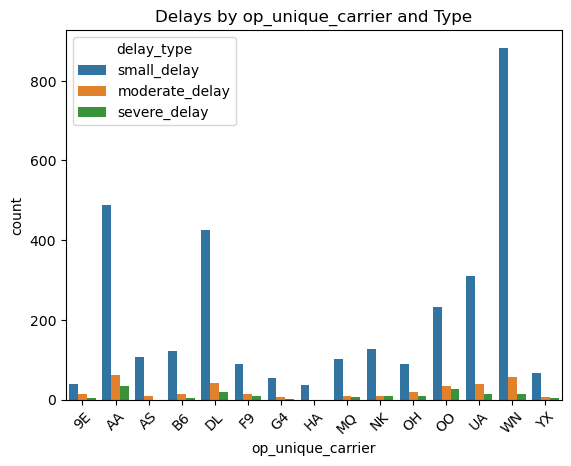

In [89]:
# Group by op_unique_carrier, sum delay counts
group_col = 'op_unique_carrier' 

delay_by_group = flight_df.groupby(group_col)[delay_types].sum().reset_index()
delay_melted_group = delay_by_group.melt(id_vars=group_col, var_name='delay_type', value_name='count')

sns.barplot(x=group_col, y='count', hue='delay_type', data=delay_melted_group)
plt.title(f'Delays by {group_col} and Type')
plt.xticks(rotation=45)
plt.show()


#### Delays by origin and type

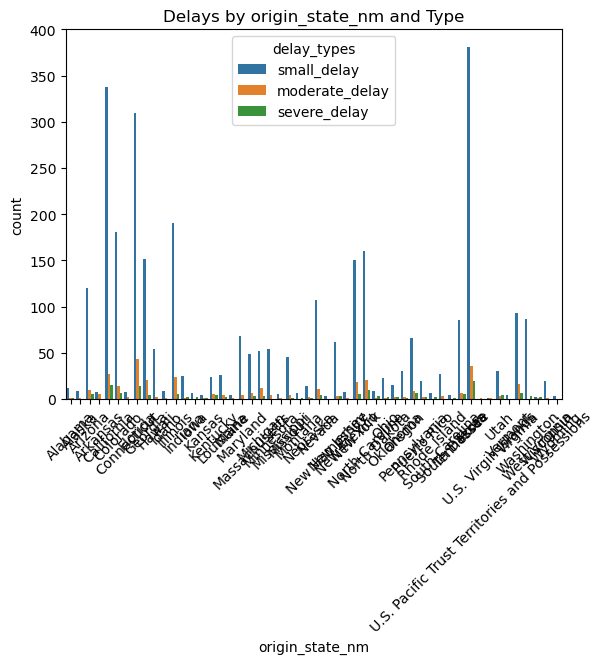

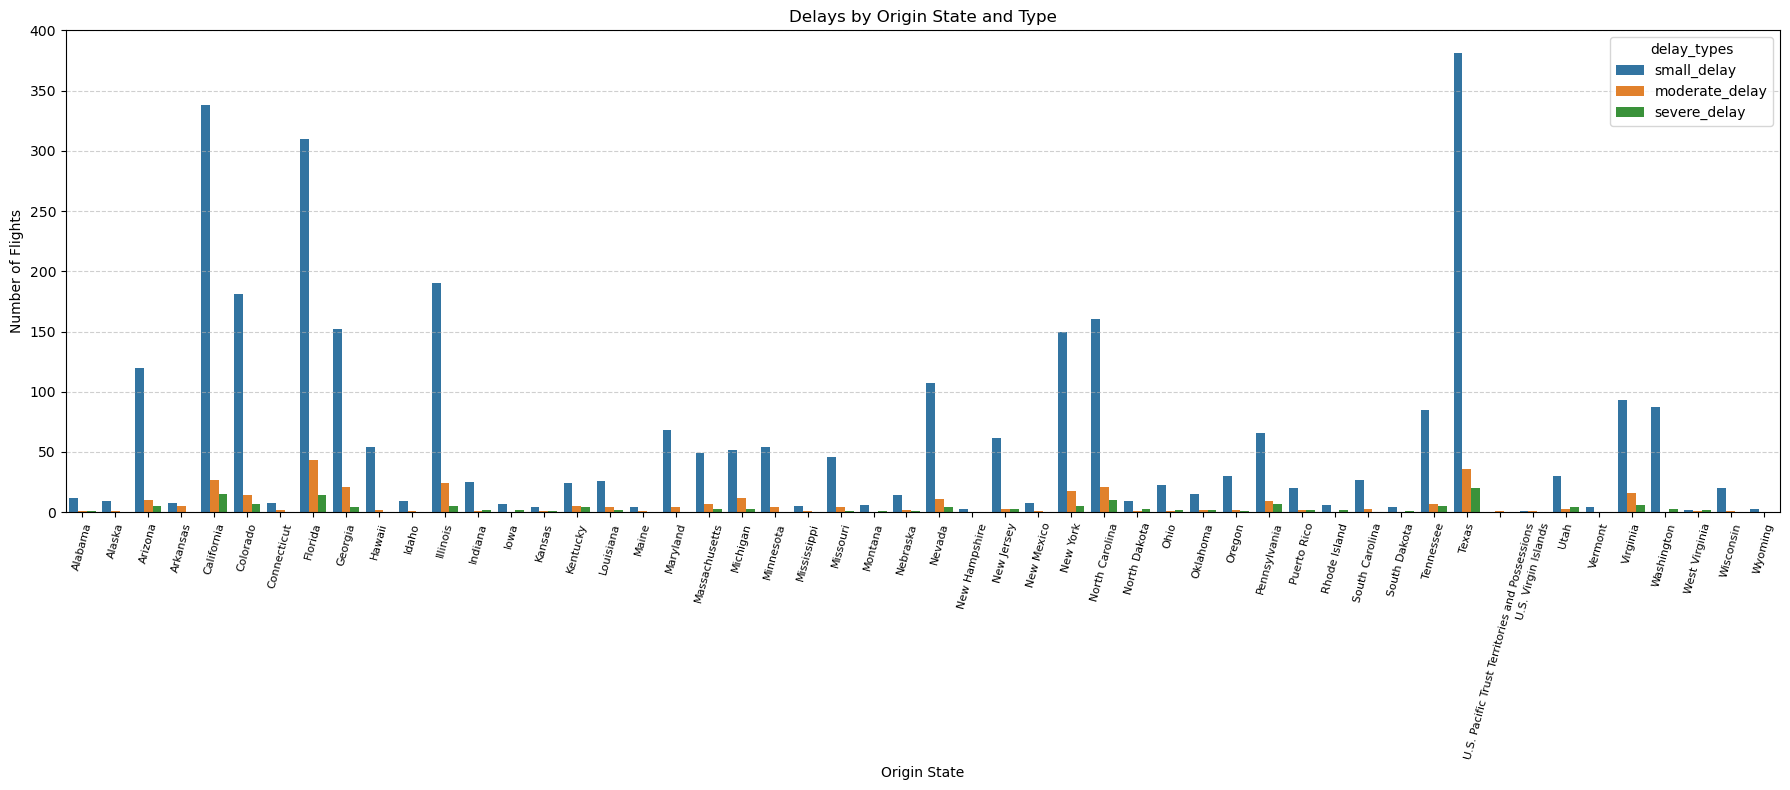

In [95]:
# Group by origin, sum delay counts
group_col = 'origin_state_nm' 

delay_by_group = flight_df.groupby(group_col)[delay_types].sum().reset_index()
delay_melted_group = delay_by_group.melt(id_vars=group_col, var_name='delay_types', value_name='count')

sns.barplot(x=group_col, y='count', hue='delay_types', data=delay_melted_group)
plt.title(f'Delays by {group_col} and Type')
plt.xticks(rotation=45)
plt.show()

# Use of AI to make the graph more readable
# Group and melt as before
delay_by_state = flight_df.groupby('origin_state_nm')[delay_types].sum().reset_index()
delay_melted = delay_by_state.melt(id_vars='origin_state_nm', var_name='delay_types', value_name='count')

# Optional: sort states alphabetically or by total delays
state_order = delay_by_state.sort_values('origin_state_nm')['origin_state_nm']

plt.figure(figsize=(18,8))  # wider for all states
sns.barplot(x='origin_state_nm', y='count', hue='delay_types', data=delay_melted, order=state_order)
plt.title('Delays by Origin State and Type')
plt.xticks(rotation=75, fontsize=8)  # rotate and shrink font for better spacing
plt.xlabel('Origin State')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Delays by destination and type

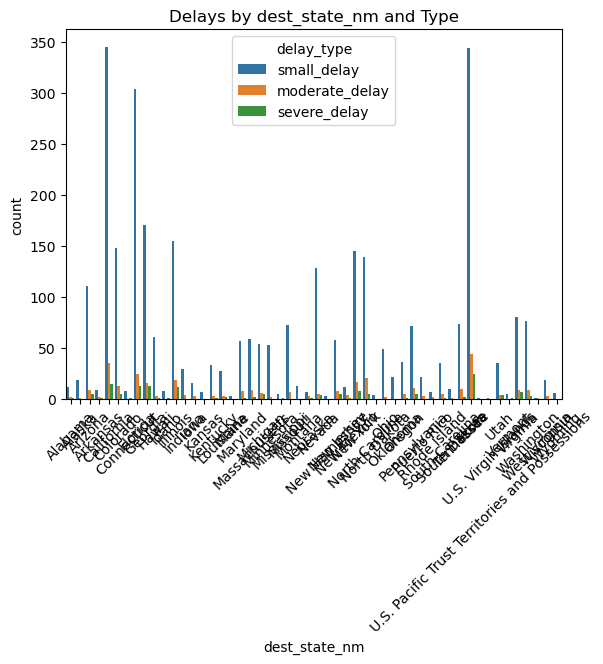

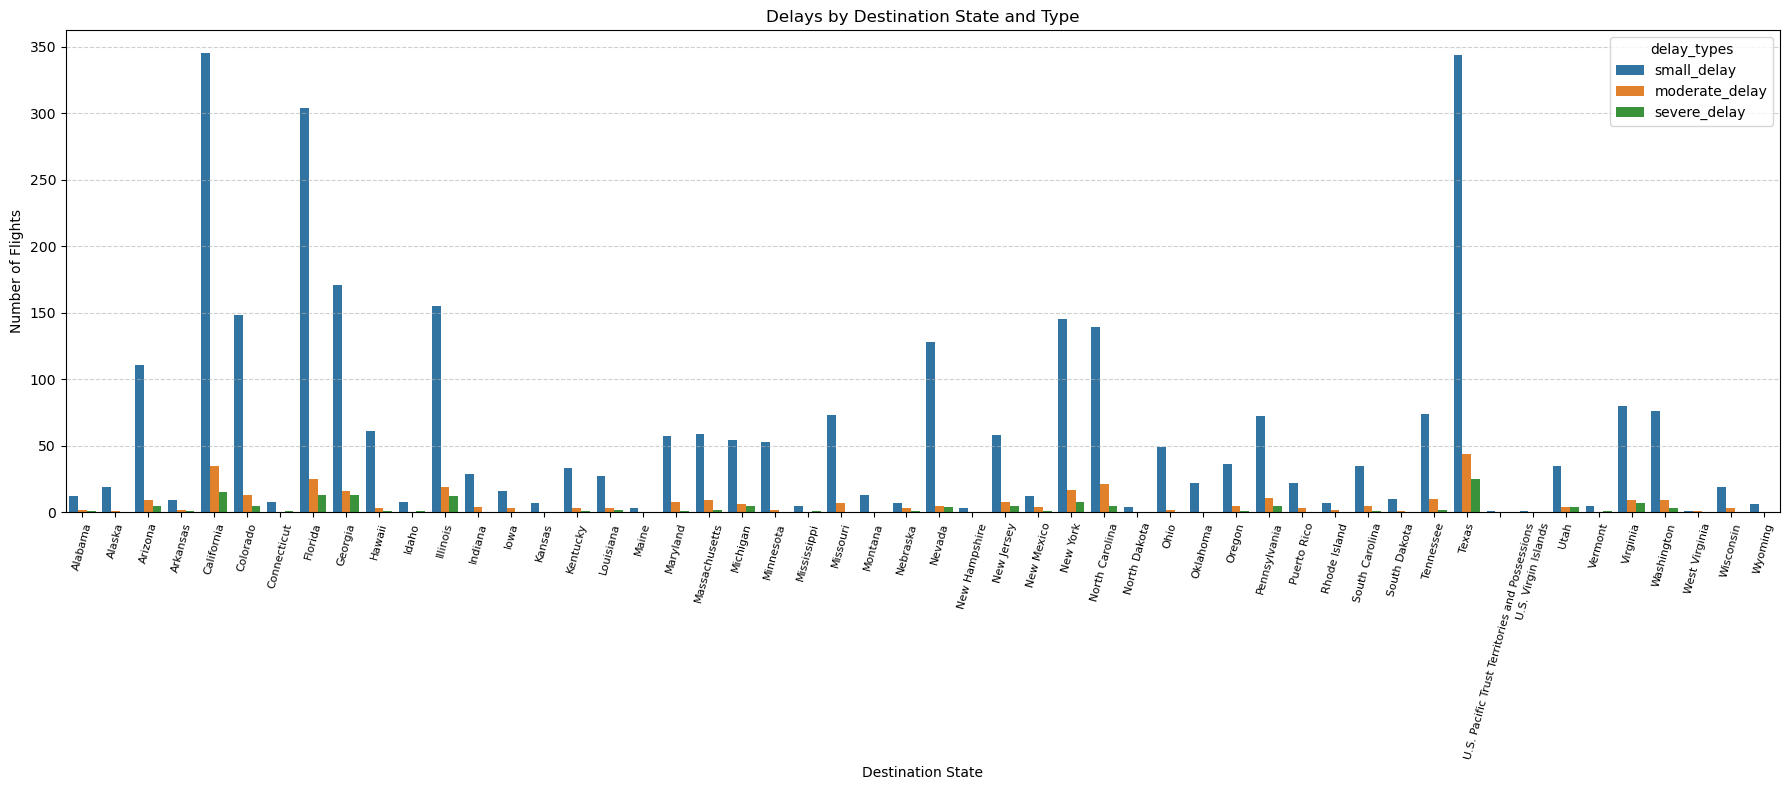

In [96]:
# Group by destination, sum delay counts
group_col = 'dest_state_nm' 

delay_by_group = flight_df.groupby(group_col)[delay_types].sum().reset_index()
delay_melted_group = delay_by_group.melt(id_vars=group_col, var_name='delay_type', value_name='count')

sns.barplot(x=group_col, y='count', hue='delay_type', data=delay_melted_group)
plt.title(f'Delays by {group_col} and Type')
plt.xticks(rotation=45)
plt.show()

# Use of AI to make the graph more readable
# Group and melt as before
delay_by_state = flight_df.groupby('dest_state_nm')[delay_types].sum().reset_index()
delay_melted = delay_by_state.melt(id_vars='dest_state_nm', var_name='delay_types', value_name='count')

# Optional: sort states alphabetically or by total delays
state_order = delay_by_state.sort_values('dest_state_nm')['dest_state_nm']

plt.figure(figsize=(18,8))  # wider for all states
sns.barplot(x='dest_state_nm', y='count', hue='delay_types', data=delay_melted, order=state_order)
plt.title('Delays by Destination State and Type')
plt.xticks(rotation=75, fontsize=8)  # rotate and shrink font for better spacing
plt.xlabel('Destination State')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Scatterplot

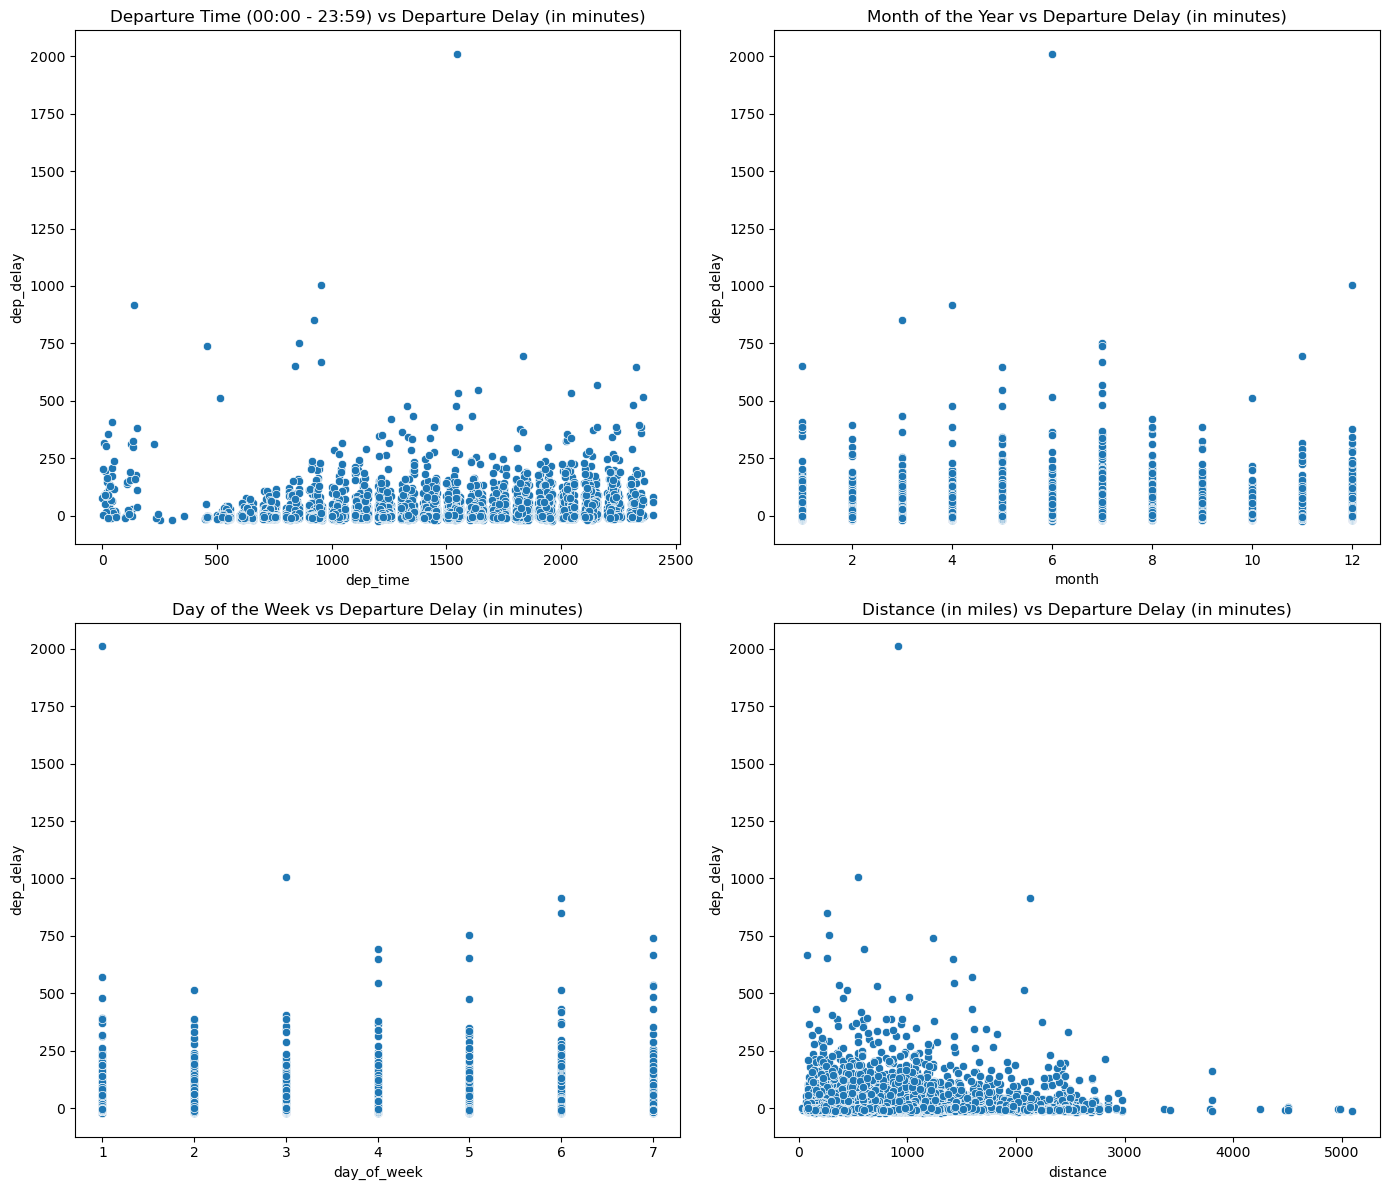

In [86]:
# Prepare a 2x2 grid of scatterplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# dep_time vs dep_delay
sns.scatterplot(data=flight_df, x='dep_time', y='dep_delay', ax=axes[0,0])
axes[0,0].set_title('Departure Time (00:00 - 23:59) vs Departure Delay (in minutes)')

# month vs dep_delay
sns.scatterplot(data=flight_df, x='month', y='dep_delay', ax=axes[0,1])
axes[0,1].set_title('Month of the Year vs Departure Delay (in minutes)')

# day_of_week vs dep_delay
sns.scatterplot(data=flight_df, x='day_of_week', y='dep_delay', ax=axes[1,0])
axes[1,0].set_title('Day of the Week vs Departure Delay (in minutes)')

# distance vs dep_delay
sns.scatterplot(data=flight_df, x='distance', y='dep_delay', ax=axes[1,1])
axes[1,1].set_title('Distance (in miles) vs Departure Delay (in minutes)')

plt.tight_layout()
plt.show()


### Correlation Matrix

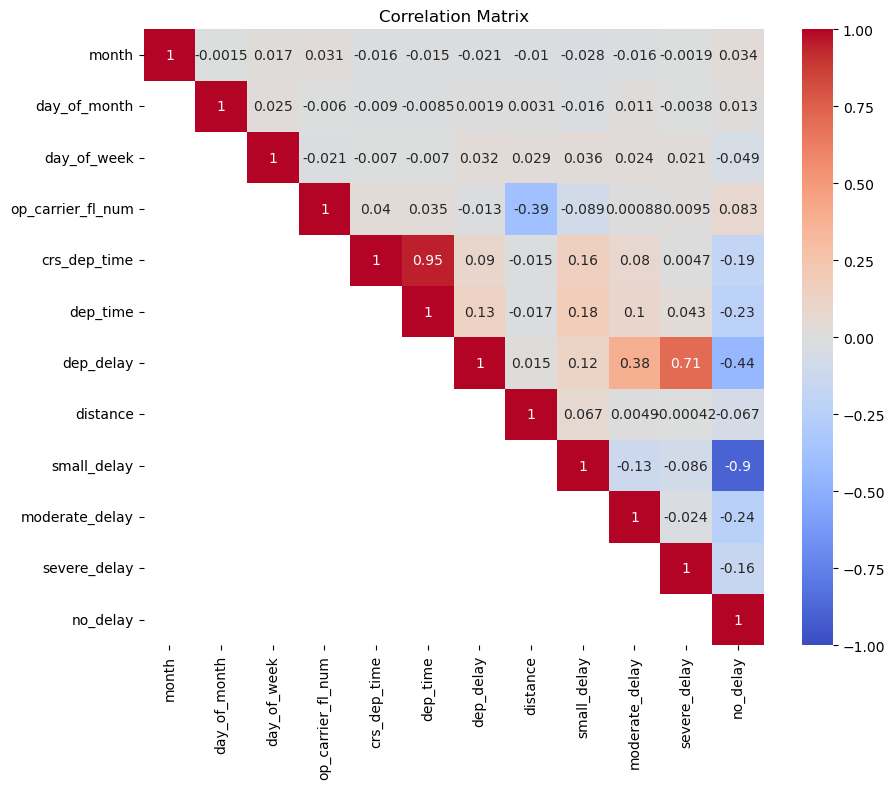

In [80]:
# Select only needed variables
numeric_df = flight_df.drop(columns=['fl_date','cancelled','year']).select_dtypes(include='number')
corr_matrix = numeric_df.corr()

mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Correlation Matrix')
plt.show()
